In [1]:
import os
import multiprocessing
os.environ["LOKY_MAX_CPU_COUNT"] = str(multiprocessing.cpu_count())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, average_precision_score
)

from xgboost import XGBClassifier

In [2]:
OUT_DIR = "outputs_nb"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TAB_DIR = os.path.join(OUT_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
SAVE_PLOTS = True

In [3]:
import re

def safe_filename(s: str) -> str:
    s = s.replace(">=", "ge").replace("<=", "le").replace(">", "gt").replace("<", "lt")
    s = s.replace("=", "eq").replace(":", "-").replace("/", "-").replace("\\", "-")
    s = s.replace(" ", "_")
    s = re.sub(r"[^A-Za-z0-9_.-]", "_", s)
    return s

def save_fig(filename, do_save=True):
    plt.tight_layout()
    if do_save and SAVE_PLOTS and filename is not None:
        path = os.path.join(FIG_DIR, safe_filename(filename))
        plt.savefig(path, dpi=150)
        print("Saved:", path)
    plt.show()
    plt.close()

def build_preprocess(X_df):
    cat_cols = X_df.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X_df.select_dtypes(exclude=["object"]).columns.tolist()
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop"
    )

def evaluate_pipeline(pipe, X_te, y_te, threshold=0.5):
    if hasattr(pipe[-1], "predict_proba"):
        y_prob = pipe.predict_proba(X_te)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
    else:
        y_prob = None
        y_pred = pipe.predict(X_te)

    out = {
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_prob) if y_prob is not None else np.nan,
        "pr_auc": average_precision_score(y_te, y_prob) if y_prob is not None else np.nan,
        "cm": confusion_matrix(y_te, y_pred),
        "y_prob": y_prob
    }
    return out

def plot_cm_heatmap(cm, title, filename=None):
    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["True 0", "True 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")

    if filename is not None:
        save_fig(filename, do_save=True)
    else:
        plt.tight_layout()
        plt.show()
        plt.close()

def plot_roc_all(trained_dict, X_te, y_te, title, filename=None):
    plt.figure(figsize=(6,5))
    for name, pipe in trained_dict.items():
        if not hasattr(pipe[-1], "predict_proba"):
            continue
        y_prob = pipe.predict_proba(X_te)[:, 1]
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        auc = roc_auc_score(y_te, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.legend(loc="lower right")
    if filename is not None:
        save_fig(filename, do_save=True)
    else:
        plt.tight_layout(); plt.show(); plt.close()

def plot_pr_all(trained_dict, X_te, y_te, title, filename=None):
    plt.figure(figsize=(6,5))
    for name, pipe in trained_dict.items():
        if not hasattr(pipe[-1], "predict_proba"):
            continue
        y_prob = pipe.predict_proba(X_te)[:, 1]
        prec, rec, _ = precision_recall_curve(y_te, y_prob)
        ap = average_precision_score(y_te, y_prob)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    if filename is not None:
        save_fig(filename, do_save=True)
    else:
        plt.tight_layout(); plt.show(); plt.close()

In [4]:
df_raw = pd.read_csv("BankChurners.csv")
print("Raw shape:", df_raw.shape)

leak_cols = [c for c in df_raw.columns if ("Naive_Bayes_Classifier" in c) or ("Naive_Bayes" in c)]
df_raw = df_raw.drop(columns=leak_cols, errors="ignore")
print("Dropped leakage cols:", leak_cols)

df = df_raw.drop(columns=["CLIENTNUM"], errors="ignore").copy()
df["churn"] = df["Attrition_Flag"].map({"Existing Customer": 0, "Attrited Customer": 1})
df = df.drop(columns=["Attrition_Flag"], errors="ignore")

print("Clean shape:", df.shape)
df.head()


Raw shape: (10127, 23)
Dropped leakage cols: ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
Clean shape: (10127, 20)


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,churn
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


Counts:
 churn
0    8500
1    1627
Name: count, dtype: int64

Ratios:
 churn
0    0.83934
1    0.16066
Name: proportion, dtype: float64
Saved: outputs_nb\figures\eda_target_distribution.png


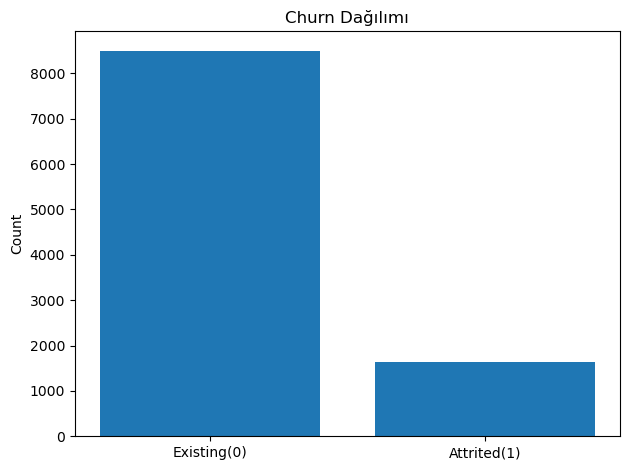

Saved: outputs_nb\figures\eda_corr_heatmap.png


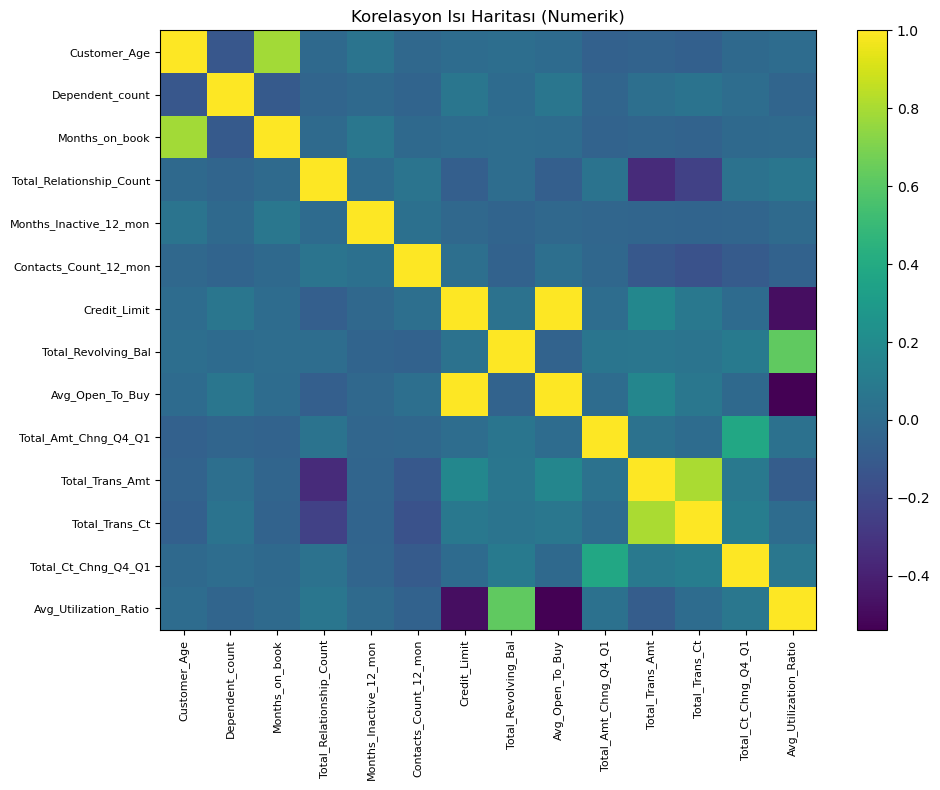

Saved: outputs_nb\tables\describe_numeric.csv


In [5]:
counts = df["churn"].value_counts()
ratios = df["churn"].value_counts(normalize=True)
print("Counts:\n", counts)
print("\nRatios:\n", ratios)

plt.figure()
plt.bar(["Existing(0)", "Attrited(1)"], [counts.get(0,0), counts.get(1,0)])
plt.title("Churn Dağılımı")
plt.ylabel("Count")
save_fig("eda_target_distribution.png", do_save=True)

num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
num_cols = [c for c in num_cols if c != "churn"]
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=8)
plt.yticks(range(len(num_cols)), num_cols, fontsize=8)
plt.title("Korelasyon Isı Haritası (Numerik)")
save_fig("eda_corr_heatmap.png", do_save=True)

desc_path = os.path.join(TAB_DIR, "describe_numeric.csv")
df[num_cols].describe().to_csv(desc_path, index=True)
print("Saved:", desc_path)


In [6]:
X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("TRAIN churn counts:\n", y_train.value_counts())
print("TEST  churn counts:\n", y_test.value_counts())


TRAIN churn counts:
 churn
0    6799
1    1302
Name: count, dtype: int64
TEST  churn counts:
 churn
0    1701
1     325
Name: count, dtype: int64


  File "C:\Users\yaren\anaconda3\envs\yapaysinir\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "C:\Users\yaren\anaconda3\envs\yapaysinir\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\yaren\anaconda3\envs\yapaysinir\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yaren\anaconda3\envs\yapaysinir\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    

Saved: outputs_nb\figures\kmeans_elbow.png


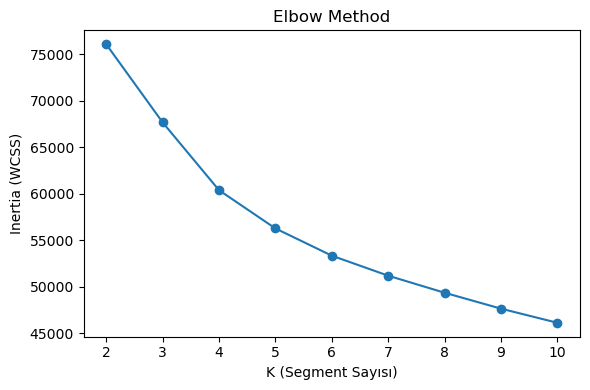

Saved: outputs_nb\figures\kmeans_silhouette.png


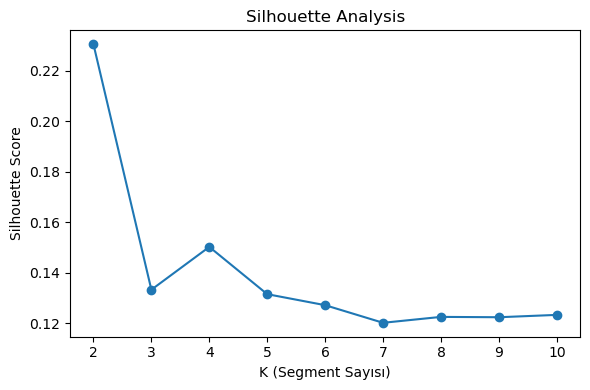

Silhouette'a göre önerilen k: 2
Train segment counts:
 segment
0    1156
3    1135
4    1085
1    1017
8     962
9     826
7     783
5     452
6     378
2     307
Name: count, dtype: int64
Test  segment counts:
 segment
0    288
3    277
4    261
1    244
9    235
8    230
7    203
5    116
2     91
6     81
Name: count, dtype: int64


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct,churn
segment,,,,,,,,,,,,
0,44.371972,3.078720,34.216263,4.615917,2.148789,3.137543,5645.520242,1775.405709,3870.114533,3003.739619,55.760381,0.125433
1,46.705015,2.709931,36.186824,2.112094,2.076696,1.974435,5271.063324,1491.702065,3779.361259,5348.204523,79.617502,0.064897
2,46.055375,2.547231,35.478827,2.084691,2.234528,2.198697,30469.328990,1334.182410,29135.146580,11075.273616,98.065147,0.104235
3,57.266960,1.007048,45.670485,4.244934,2.231718,2.564758,5411.168722,1333.731278,4077.437445,2852.038767,52.976211,0.133921
4,46.283871,2.812903,36.000922,3.425806,2.529032,3.080184,5179.354470,147.696774,5031.657696,3008.205530,51.938249,0.531797
5,45.073009,2.185841,35.212389,2.407080,2.201327,2.250000,8588.933628,1390.139381,7198.794248,14735.258850,110.424779,0.000000
6,48.566138,2.351852,38.735450,4.037037,4.796296,2.275132,5081.283598,1084.243386,3997.040212,3923.732804,66.886243,0.156085
7,46.446999,2.641124,36.192848,4.247765,2.307791,2.568327,27476.679438,1141.154534,26335.524904,2921.595147,54.430396,0.159642
8,46.064449,2.875260,35.814969,4.979210,2.113306,1.257796,5059.449896,990.071726,4069.378170,3889.070686,68.885655,0.043659


In [7]:
seg_features = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",
    "Total_Trans_Amt",
    "Total_Trans_Ct"
]

seg_scaler = StandardScaler()
Xseg_train_scaled = seg_scaler.fit_transform(X_train[seg_features])

# Elbow + Silhouette
K = range(2, 11)

inertias = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xseg_train_scaled)
    inertias.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(list(K), inertias, marker="o")
plt.xlabel("K (Segment Sayısı)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")
save_fig("kmeans_elbow.png", do_save=True)

sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xseg_train_scaled)
    sil_scores.append(silhouette_score(Xseg_train_scaled, labels))
plt.figure(figsize=(6,4))
plt.plot(list(K), sil_scores, marker="o")
plt.xlabel("K (Segment Sayısı)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
save_fig("kmeans_silhouette.png", do_save=True)

best_k = list(K)[int(np.argmax(sil_scores))]
print("Silhouette'a göre önerilen k:", best_k)

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xseg_train_scaled)

X_train_seg = X_train.copy()
X_test_seg  = X_test.copy()
X_train_seg["segment"] = kmeans.predict(seg_scaler.transform(X_train_seg[seg_features])).astype(str)
X_test_seg["segment"]  = kmeans.predict(seg_scaler.transform(X_test_seg[seg_features])).astype(str)

print("Train segment counts:\n", X_train_seg["segment"].value_counts())
print("Test  segment counts:\n", X_test_seg["segment"].value_counts())

tmp = X_train_seg.copy()
tmp["churn"] = y_train.values
segment_summary = tmp.groupby("segment")[seg_features + ["churn"]].mean()
segment_summary


Saved: outputs_nb\figures\segment_churn_rates.png


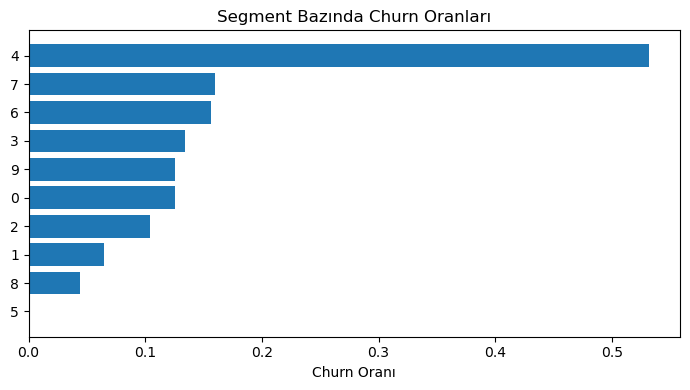

Saved segment tables.


In [8]:
churn_by_segment = tmp.groupby("segment")["churn"].mean().sort_values()

plt.figure(figsize=(7,4))
plt.barh(churn_by_segment.index, churn_by_segment.values)
plt.xlabel("Churn Oranı")
plt.title("Segment Bazında Churn Oranları")
save_fig("segment_churn_rates.png", do_save=True)

segment_summary.to_csv(os.path.join(TAB_DIR, "segment_summary_means.csv"))
churn_by_segment.to_csv(os.path.join(TAB_DIR, "segment_churn_rates.csv"))
print("Saved segment tables.")


In [9]:
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

models_base = {
    "LogReg": LogisticRegression(max_iter=3000, class_weight="balanced"),
    "RF": RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=1, class_weight="balanced_subsample"
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=2000,
        random_state=42,
        early_stopping=True
    ),
    "XGB": XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )
}


scale_pos_weight: 5.221966205837173


Saved: outputs_nb\figures\cm_baseline_no_segment_LogReg.png


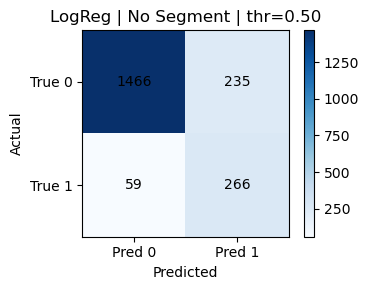

Saved: outputs_nb\figures\cm_baseline_no_segment_RF.png


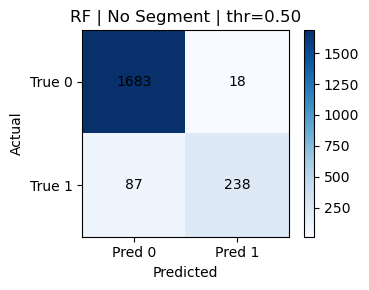

Saved: outputs_nb\figures\cm_baseline_no_segment_MLP.png


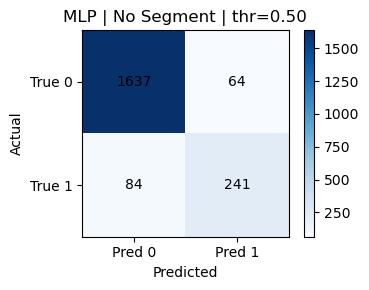

Saved: outputs_nb\figures\cm_baseline_no_segment_XGB.png


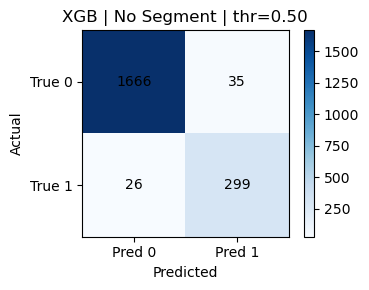

,type,scenario,model,accuracy,precision,recall,f1,roc_auc,pr_auc
3,baseline,no_segment,XGB,0.969891,0.895210,0.920000,0.907436,0.993159,0.969973
1,baseline,no_segment,RF,0.948174,0.929688,0.732308,0.819277,0.985825,0.939899
2,baseline,no_segment,MLP,0.926950,0.790164,0.741538,0.765079,0.958940,0.857781
0,baseline,no_segment,LogReg,0.854886,0.530938,0.818462,0.644068,0.920677,0.731488


In [10]:
pre_no = build_preprocess(X_train)

trained_no = {}
rows_no = []

for name, mdl in models_base.items():
    pipe = Pipeline([("prep", pre_no), ("model", clone(mdl))])
    pipe.fit(X_train, y_train)

    m = evaluate_pipeline(pipe, X_test, y_test, threshold=0.5)
    trained_no[name] = pipe

    rows_no.append({
        "type": "baseline",
        "scenario": "no_segment",
        "model": name,
        **{k:m[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}
    })

    plot_cm_heatmap(m["cm"], f"{name} | No Segment | thr=0.50", f"cm_baseline_no_segment_{name}.png")

results_no = pd.DataFrame(rows_no).sort_values("pr_auc", ascending=False)
results_no.to_csv(os.path.join(TAB_DIR, "results_no_segment_baseline.csv"), index=False)
results_no


Saved: outputs_nb\figures\cm_baseline_with_segment_LogReg.png


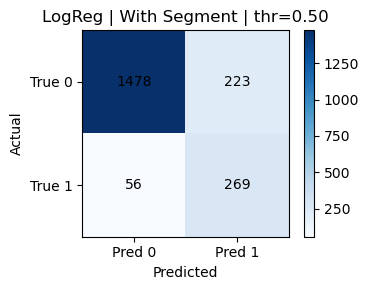

Saved: outputs_nb\figures\cm_baseline_with_segment_RF.png


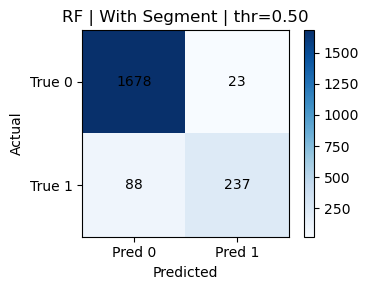

Saved: outputs_nb\figures\cm_baseline_with_segment_MLP.png


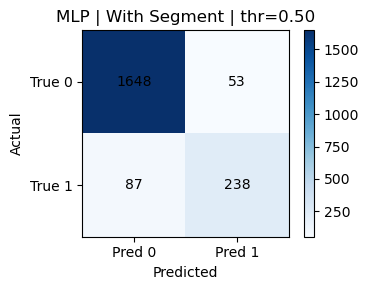

Saved: outputs_nb\figures\cm_baseline_with_segment_XGB.png


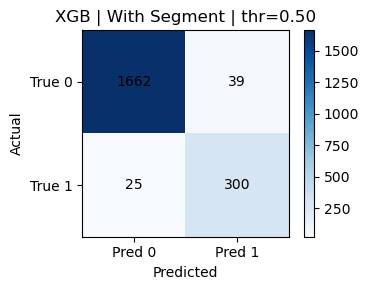

,type,scenario,model,accuracy,precision,recall,f1,roc_auc,pr_auc
3,baseline,with_segment,XGB,0.968411,0.884956,0.923077,0.903614,0.993153,0.969767
1,baseline,with_segment,RF,0.945212,0.911538,0.729231,0.810256,0.983658,0.929844
2,baseline,with_segment,MLP,0.930898,0.817869,0.732308,0.772727,0.956420,0.849252
0,baseline,with_segment,LogReg,0.862290,0.546748,0.827692,0.658507,0.931955,0.761168


In [11]:
X_train_seg_use = X_train_seg.copy()
X_test_seg_use  = X_test_seg.copy()

pre_seg = build_preprocess(X_train_seg_use)

trained_seg = {}
rows_seg = []

for name, mdl in models_base.items():
    pipe = Pipeline([("prep", pre_seg), ("model", clone(mdl))])
    pipe.fit(X_train_seg_use, y_train)

    m = evaluate_pipeline(pipe, X_test_seg_use, y_test, threshold=0.5)
    trained_seg[name] = pipe

    rows_seg.append({
        "type": "baseline",
        "scenario": "with_segment",
        "model": name,
        **{k:m[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}
    })

    plot_cm_heatmap(m["cm"], f"{name} | With Segment | thr=0.50", f"cm_baseline_with_segment_{name}.png")

results_seg = pd.DataFrame(rows_seg).sort_values("pr_auc", ascending=False)
results_seg.to_csv(os.path.join(TAB_DIR, "results_with_segment_baseline.csv"), index=False)
results_seg


Saved: outputs_nb\figures\roc_baseline_no_segment.png


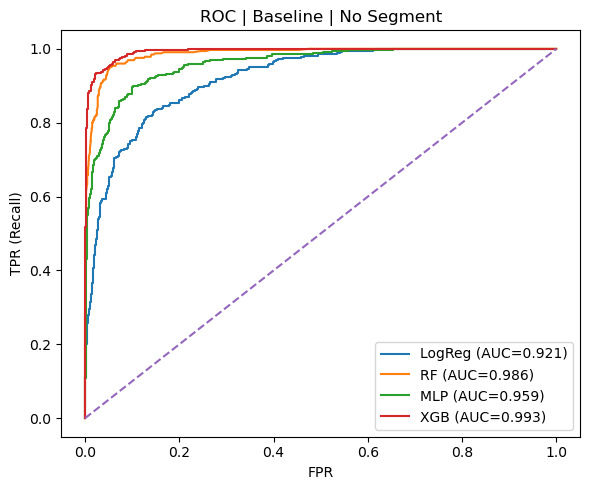

Saved: outputs_nb\figures\pr_baseline_no_segment.png


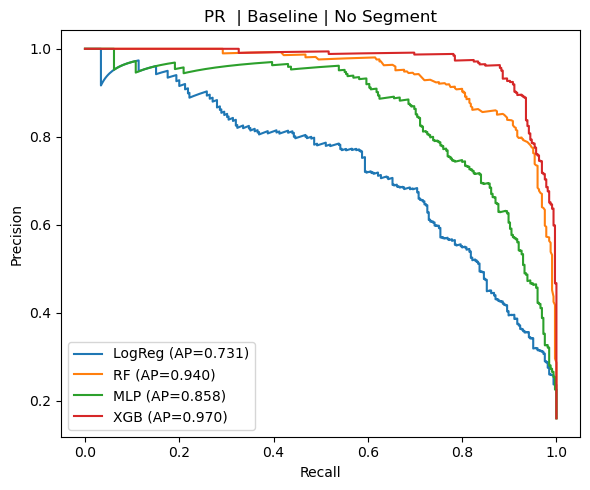

Saved: outputs_nb\figures\roc_baseline_with_segment.png


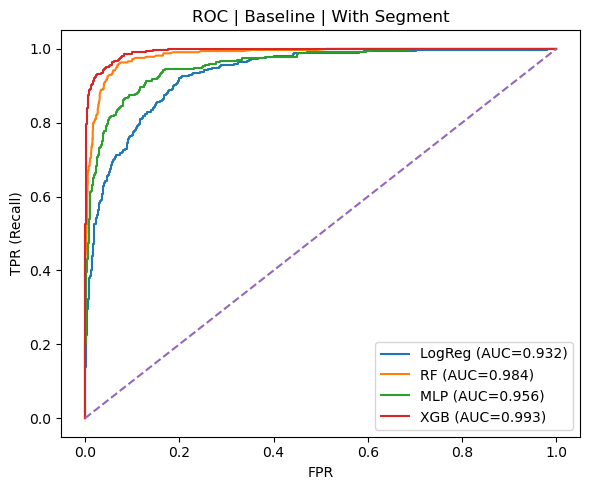

Saved: outputs_nb\figures\pr_baseline_with_segment.png


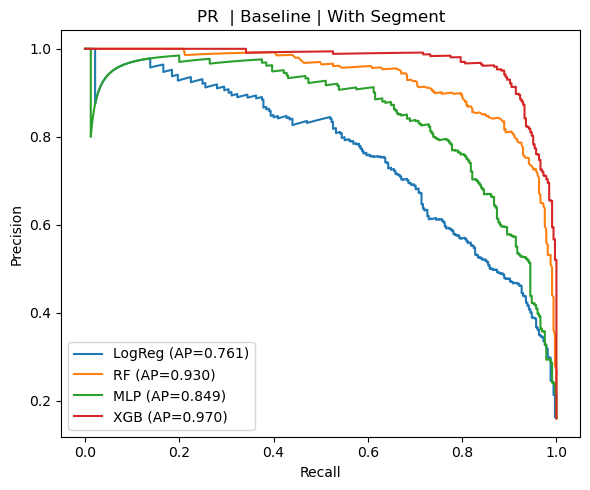

In [12]:
plot_roc_all(trained_no, X_test, y_test, "ROC | Baseline | No Segment", "roc_baseline_no_segment.png")
plot_pr_all(trained_no, X_test, y_test, "PR  | Baseline | No Segment", "pr_baseline_no_segment.png")

plot_roc_all(trained_seg, X_test_seg_use, y_test, "ROC | Baseline | With Segment", "roc_baseline_with_segment.png")
plot_pr_all(trained_seg, X_test_seg_use, y_test, "PR  | Baseline | With Segment", "pr_baseline_with_segment.png")


In [13]:
compare_base = pd.concat([results_no, results_seg], ignore_index=True)
compare_base = compare_base.sort_values(["model","scenario"])
compare_base.to_csv(os.path.join(TAB_DIR, "compare_baseline_two_scenarios.csv"), index=False)
compare_base


,type,scenario,model,accuracy,precision,recall,f1,roc_auc,pr_auc
3,baseline,no_segment,LogReg,0.854886,0.530938,0.818462,0.644068,0.920677,0.731488
7,baseline,with_segment,LogReg,0.862290,0.546748,0.827692,0.658507,0.931955,0.761168
2,baseline,no_segment,MLP,0.926950,0.790164,0.741538,0.765079,0.958940,0.857781
6,baseline,with_segment,MLP,0.930898,0.817869,0.732308,0.772727,0.956420,0.849252
1,baseline,no_segment,RF,0.948174,0.929688,0.732308,0.819277,0.985825,0.939899
5,baseline,with_segment,RF,0.945212,0.911538,0.729231,0.810256,0.983658,0.929844
0,baseline,no_segment,XGB,0.969891,0.895210,0.920000,0.907436,0.993159,0.969973
4,baseline,with_segment,XGB,0.968411,0.884956,0.923077,0.903614,0.993153,0.969767


Saved: outputs_nb\figures\compare_pr_auc_segment_yes_no_baseline.png


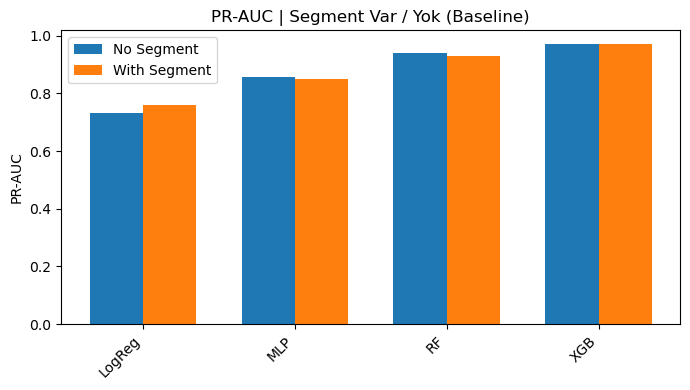

In [14]:
pivot_pr = compare_base.pivot(index="model", columns="scenario", values="pr_auc")

plt.figure(figsize=(7,4))
x = np.arange(len(pivot_pr.index))
w = 0.35
plt.bar(x - w/2, pivot_pr["no_segment"], width=w, label="No Segment")
plt.bar(x + w/2, pivot_pr["with_segment"], width=w, label="With Segment")
plt.xticks(x, pivot_pr.index, rotation=45, ha="right")
plt.ylabel("PR-AUC")
plt.title("PR-AUC | Segment Var / Yok (Baseline)")
plt.legend()
save_fig("compare_pr_auc_segment_yes_no_baseline.png", do_save=True)


In [15]:
mlp_grid = {
    "hidden_layer_sizes": [(64,32), (128,64), (128,64,32)],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
    "activation": ["relu", "tanh"]
}

Xtr = X_train_seg_use
Xte = X_test_seg_use
pre = build_preprocess(Xtr)

mlp_rows = []
mlp_pipes = {}

combos = list(product(
    mlp_grid["hidden_layer_sizes"],
    mlp_grid["alpha"],
    mlp_grid["learning_rate_init"],
    mlp_grid["activation"]
))
print("MLP combos:", len(combos))

for i, (h, a, lr, act) in enumerate(combos, start=1):
    mdl = MLPClassifier(
        hidden_layer_sizes=h,
        alpha=a,
        learning_rate_init=lr,
        activation=act,
        solver="adam",
        max_iter=2500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=25
    )
    pipe = Pipeline([("prep", pre), ("model", mdl)])
    pipe.fit(Xtr, y_train)
    m = evaluate_pipeline(pipe, Xte, y_test, threshold=0.5)

    mlp_rows.append({
        "id": i,
        "hidden_layer_sizes": str(h),
        "alpha": a,
        "lr": lr,
        "activation": act,
        **{k:m[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}
    })
    mlp_pipes[i] = pipe

mlp_results = pd.DataFrame(mlp_rows).sort_values("pr_auc", ascending=False)
mlp_results.to_csv(os.path.join(TAB_DIR, "mlp_param_search_with_segment.csv"), index=False)
mlp_results.head(10)


MLP combos: 36


,id,hidden_layer_sizes,alpha,lr,activation,accuracy,precision,recall,f1,roc_auc,pr_auc
23,24,"(128, 64)",0.0100,0.010,tanh,0.960020,0.901316,0.843077,0.871224,0.982314,0.935592
19,20,"(128, 64)",0.0010,0.010,tanh,0.952122,0.880000,0.812308,0.844800,0.979373,0.921014
33,34,"(128, 64, 32)",0.0100,0.001,tanh,0.950642,0.891986,0.787692,0.836601,0.980612,0.917784
29,30,"(128, 64, 32)",0.0010,0.001,tanh,0.950148,0.891608,0.784615,0.834697,0.979753,0.916771
25,26,"(128, 64, 32)",0.0001,0.001,tanh,0.950148,0.888889,0.787692,0.835237,0.979692,0.916488
15,16,"(128, 64)",0.0001,0.010,tanh,0.951629,0.882155,0.806154,0.842444,0.976649,0.914848
27,28,"(128, 64, 32)",0.0001,0.010,tanh,0.949161,0.872483,0.800000,0.834671,0.977071,0.911750
35,36,"(128, 64, 32)",0.0100,0.010,tanh,0.944719,0.876325,0.763077,0.815789,0.975115,0.909786
21,22,"(128, 64)",0.0100,0.001,tanh,0.948174,0.864238,0.803077,0.832536,0.976486,0.906439
11,12,"(64, 32)",0.0100,0.010,tanh,0.944225,0.855705,0.784615,0.818620,0.975448,0.904448


In [16]:
xgb_grid = {
    "max_depth": [3, 4, 6],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [300, 500],
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8, 0.9]
}

Xtr = X_train_seg_use
Xte = X_test_seg_use
pre = build_preprocess(Xtr)

xgb_rows = []
xgb_pipes = {}

combos = list(product(
    xgb_grid["max_depth"],
    xgb_grid["learning_rate"],
    xgb_grid["n_estimators"],
    xgb_grid["subsample"],
    xgb_grid["colsample_bytree"]
))
print("XGB combos:", len(combos))

for i, (md, lr, ne, ss, cs) in enumerate(combos, start=1):
    mdl = XGBClassifier(
        max_depth=md,
        learning_rate=lr,
        n_estimators=ne,
        subsample=ss,
        colsample_bytree=cs,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )
    pipe = Pipeline([("prep", pre), ("model", mdl)])
    pipe.fit(Xtr, y_train)
    m = evaluate_pipeline(pipe, Xte, y_test, threshold=0.5)

    xgb_rows.append({
        "id": i,
        "max_depth": md,
        "learning_rate": lr,
        "n_estimators": ne,
        "subsample": ss,
        "colsample_bytree": cs,
        **{k:m[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}
    })
    xgb_pipes[i] = pipe

xgb_results = pd.DataFrame(xgb_rows).sort_values("pr_auc", ascending=False)
xgb_results.to_csv(os.path.join(TAB_DIR, "xgb_param_search_with_segment.csv"), index=False)
xgb_results.head(10)


XGB combos: 72


,id,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,accuracy,precision,recall,f1,roc_auc,pr_auc
43,44,4,0.10,300,0.9,0.9,0.973840,0.925000,0.910769,0.917829,0.993801,0.972089
37,38,4,0.05,500,0.8,0.9,0.972853,0.909091,0.923077,0.916031,0.993692,0.970922
42,43,4,0.10,300,0.9,0.8,0.973840,0.922360,0.913846,0.918083,0.993443,0.970512
39,40,4,0.05,500,0.9,0.9,0.973840,0.914634,0.923077,0.918836,0.993432,0.970430
38,39,4,0.05,500,0.9,0.8,0.975321,0.917933,0.929231,0.923547,0.993387,0.969958
52,53,6,0.03,500,0.8,0.8,0.970879,0.910494,0.907692,0.909091,0.993490,0.969936
47,48,4,0.10,500,0.9,0.9,0.974827,0.936306,0.904615,0.920188,0.993284,0.969862
13,14,3,0.05,500,0.8,0.9,0.969891,0.885965,0.932308,0.908546,0.993302,0.969789
36,37,4,0.05,500,0.8,0.8,0.973346,0.919505,0.913846,0.916667,0.993492,0.969563
23,24,3,0.10,500,0.9,0.9,0.971866,0.911043,0.913846,0.912442,0.993159,0.969553


In [17]:
best_mlp_cfg = mlp_results.iloc[0].to_dict()
best_mlp_model = MLPClassifier(
    hidden_layer_sizes=eval(best_mlp_cfg["hidden_layer_sizes"]),
    alpha=float(best_mlp_cfg["alpha"]),
    learning_rate_init=float(best_mlp_cfg["lr"]),
    activation=best_mlp_cfg["activation"],
    solver="adam",
    max_iter=2500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=25
)

best_xgb_cfg = xgb_results.iloc[0].to_dict()
best_xgb_model = XGBClassifier(
    max_depth=int(best_xgb_cfg["max_depth"]),
    learning_rate=float(best_xgb_cfg["learning_rate"]),
    n_estimators=int(best_xgb_cfg["n_estimators"]),
    subsample=float(best_xgb_cfg["subsample"]),
    colsample_bytree=float(best_xgb_cfg["colsample_bytree"]),
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

print("Best MLP:", best_mlp_cfg)
print("Best XGB:", best_xgb_cfg)


Best MLP: {'id': 24, 'hidden_layer_sizes': '(128, 64)', 'alpha': 0.01, 'lr': 0.01, 'activation': 'tanh', 'accuracy': 0.9600197433366239, 'precision': 0.9013157894736842, 'recall': 0.8430769230769231, 'f1': 0.8712241653418124, 'roc_auc': 0.9823144756478089, 'pr_auc': 0.9355924963954807}
Best XGB: {'id': 44.0, 'max_depth': 4.0, 'learning_rate': 0.1, 'n_estimators': 300.0, 'subsample': 0.9, 'colsample_bytree': 0.9, 'accuracy': 0.9738400789733465, 'precision': 0.925, 'recall': 0.9107692307692308, 'f1': 0.9178294573643411, 'roc_auc': 0.9938009315787094, 'pr_auc': 0.9720885555639658}


Saved: outputs_nb\figures\cm_tuned_mlp_no_segment_thr050.png


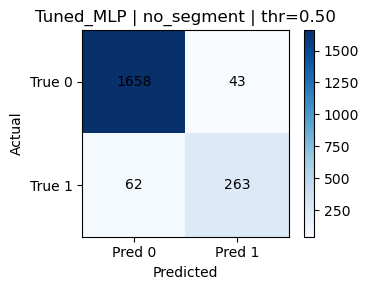

Saved: outputs_nb\figures\cm_tuned_mlp_with_segment_thr050.png


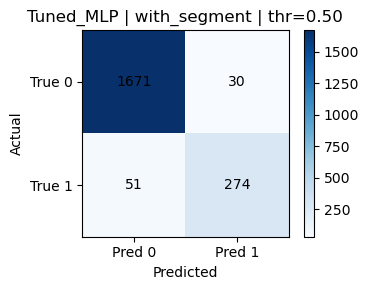

Saved: outputs_nb\figures\cm_tuned_xgb_no_segment_thr050.png


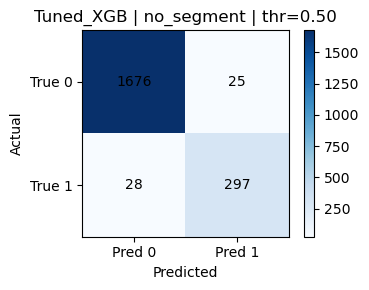

Saved: outputs_nb\figures\cm_tuned_xgb_with_segment_thr050.png


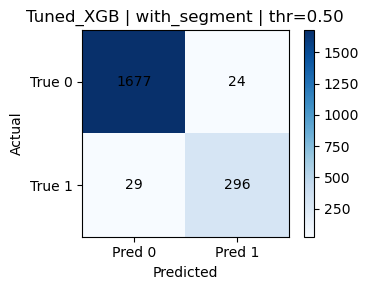

,type,scenario,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,tuned,no_segment,Tuned_MLP,0.948174,0.859477,0.809231,0.833597,0.977640,0.899358
1,tuned,with_segment,Tuned_MLP,0.960020,0.901316,0.843077,0.871224,0.982314,0.935592
2,tuned,no_segment,Tuned_XGB,0.973840,0.922360,0.913846,0.918083,0.993481,0.970956
3,tuned,with_segment,Tuned_XGB,0.973840,0.925000,0.910769,0.917829,0.993801,0.972089


In [18]:
def fit_pipe(base_model, Xtr):
    pre = build_preprocess(Xtr)
    return Pipeline([("prep", pre), ("model", clone(base_model))])

tuned_pipes = {}
tuned_rows = []

for scenario, Xtr, Xte in [
    ("no_segment",   X_train,         X_test),
    ("with_segment", X_train_seg_use, X_test_seg_use)
]:
    pipe = fit_pipe(best_mlp_model, Xtr)
    pipe.fit(Xtr, y_train)
    tuned_pipes[f"Tuned_MLP_{scenario}"] = pipe

    m = evaluate_pipeline(pipe, Xte, y_test, threshold=0.5)
    tuned_rows.append({
        "type":"tuned", "scenario":scenario, "model":"Tuned_MLP",
        **{k:m[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}
    })
    plot_cm_heatmap(m["cm"], f"Tuned_MLP | {scenario} | thr=0.50", f"cm_tuned_mlp_{scenario}_thr050.png")

for scenario, Xtr, Xte in [
    ("no_segment",   X_train,         X_test),
    ("with_segment", X_train_seg_use, X_test_seg_use)
]:
    pipe = fit_pipe(best_xgb_model, Xtr)
    pipe.fit(Xtr, y_train)
    tuned_pipes[f"Tuned_XGB_{scenario}"] = pipe

    m = evaluate_pipeline(pipe, Xte, y_test, threshold=0.5)
    tuned_rows.append({
        "type":"tuned", "scenario":scenario, "model":"Tuned_XGB",
        **{k:m[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}
    })
    plot_cm_heatmap(m["cm"], f"Tuned_XGB | {scenario} | thr=0.50", f"cm_tuned_xgb_{scenario}_thr050.png")

compare_tuned = pd.DataFrame(tuned_rows).sort_values(["model","scenario"])
compare_tuned.to_csv(os.path.join(TAB_DIR, "compare_tuned_segment_yes_no.csv"), index=False)
compare_tuned


Saved: outputs_nb\figures\roc_tuned_no_segment.png


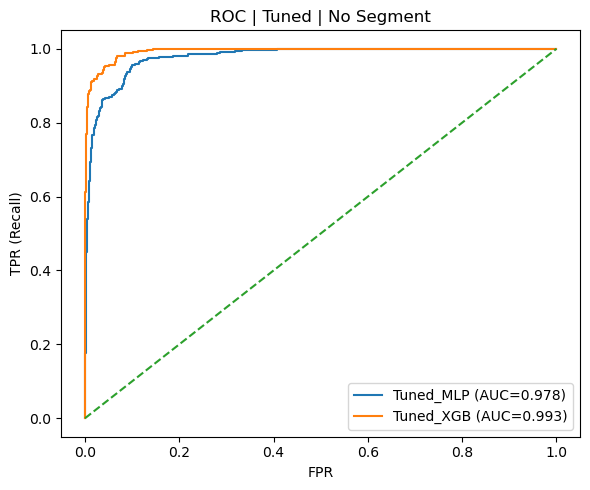

Saved: outputs_nb\figures\pr_tuned_no_segment.png


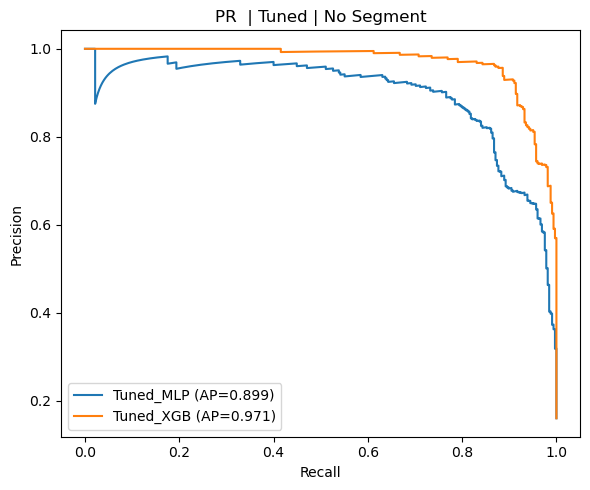

Saved: outputs_nb\figures\roc_tuned_with_segment.png


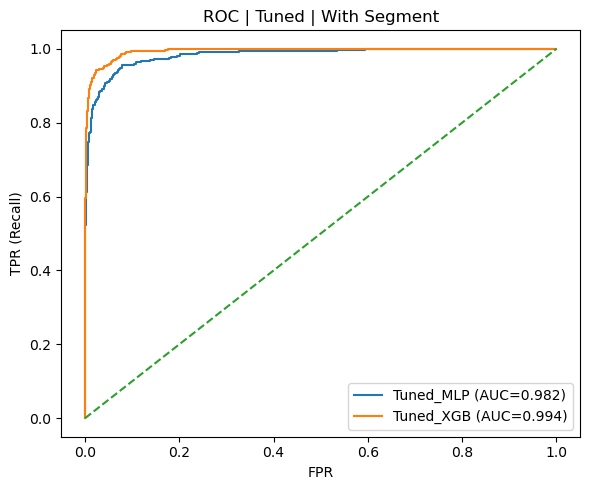

Saved: outputs_nb\figures\pr_tuned_with_segment.png


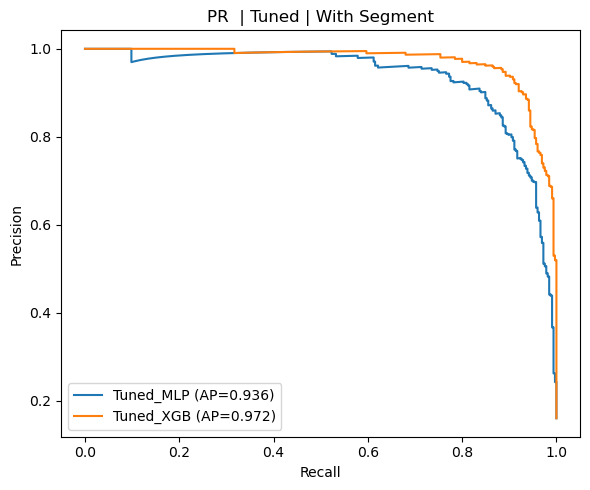

In [19]:
tuned_no = {
    "Tuned_MLP": tuned_pipes["Tuned_MLP_no_segment"],
    "Tuned_XGB": tuned_pipes["Tuned_XGB_no_segment"],
}
plot_roc_all(tuned_no, X_test, y_test, "ROC | Tuned | No Segment", "roc_tuned_no_segment.png")
plot_pr_all(tuned_no, X_test, y_test, "PR  | Tuned | No Segment", "pr_tuned_no_segment.png")

tuned_se = {
    "Tuned_MLP": tuned_pipes["Tuned_MLP_with_segment"],
    "Tuned_XGB": tuned_pipes["Tuned_XGB_with_segment"],
}
plot_roc_all(tuned_se, X_test_seg_use, y_test, "ROC | Tuned | With Segment", "roc_tuned_with_segment.png")
plot_pr_all(tuned_se, X_test_seg_use, y_test, "PR  | Tuned | With Segment", "pr_tuned_with_segment.png")


Saved: outputs_nb\figures\cm_Baseline_LogReg_no_segment_thr050.png


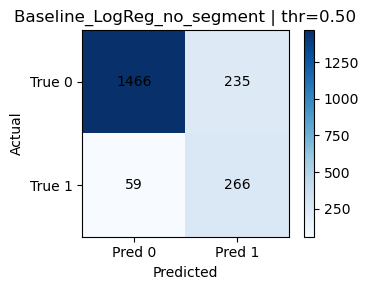

Saved: outputs_nb\figures\cm_Baseline_LogReg_no_segment_thrBEST.png


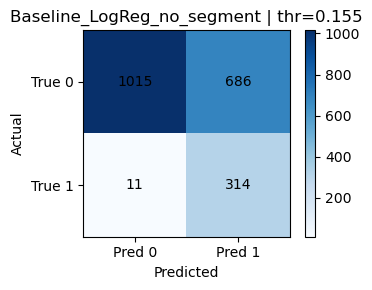

Saved: outputs_nb\figures\cm_Baseline_RF_no_segment_thr050.png


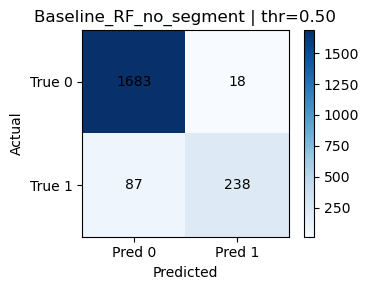

Saved: outputs_nb\figures\cm_Baseline_RF_no_segment_thrBEST.png


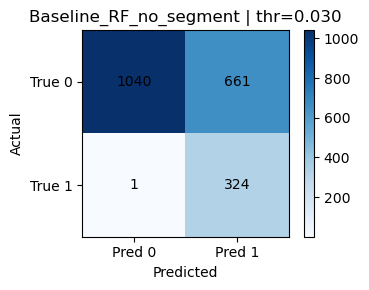

Saved: outputs_nb\figures\cm_Baseline_MLP_no_segment_thr050.png


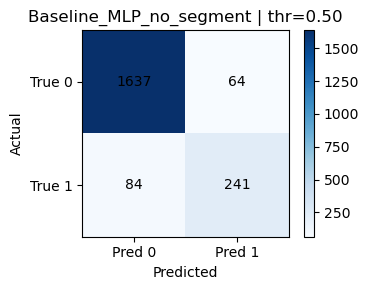

Saved: outputs_nb\figures\cm_Baseline_MLP_no_segment_thrBEST.png


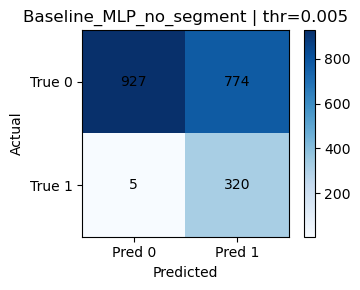

Saved: outputs_nb\figures\cm_Baseline_XGB_no_segment_thr050.png


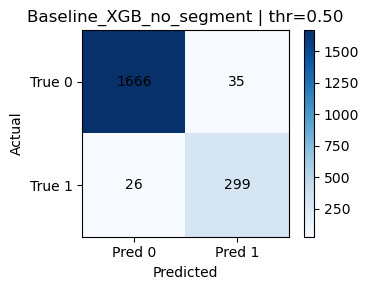

Saved: outputs_nb\figures\cm_Baseline_XGB_no_segment_thrBEST.png


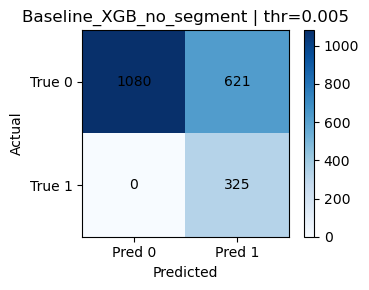

Saved: outputs_nb\figures\cm_Baseline_LogReg_with_segment_thr050.png


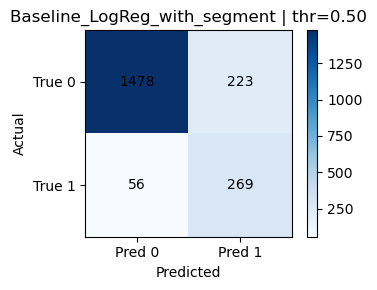

Saved: outputs_nb\figures\cm_Baseline_LogReg_with_segment_thrBEST.png


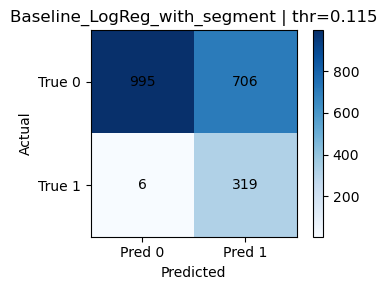

Saved: outputs_nb\figures\cm_Baseline_RF_with_segment_thr050.png


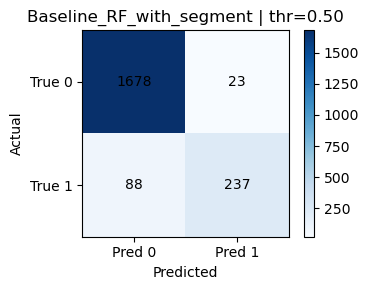

Saved: outputs_nb\figures\cm_Baseline_RF_with_segment_thrBEST.png


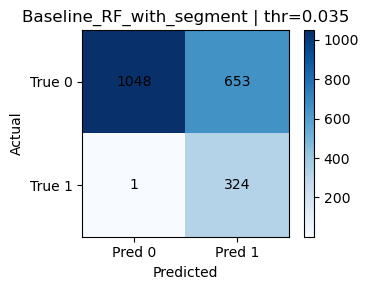

Saved: outputs_nb\figures\cm_Baseline_MLP_with_segment_thr050.png


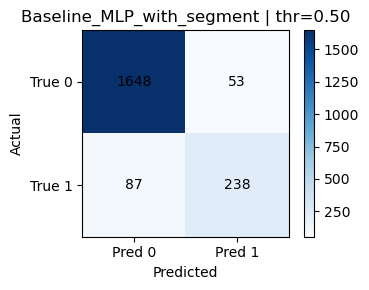

Saved: outputs_nb\figures\cm_Baseline_MLP_with_segment_thrBEST.png


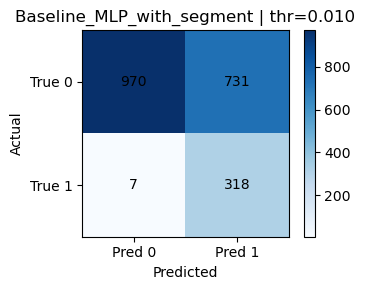

Saved: outputs_nb\figures\cm_Baseline_XGB_with_segment_thr050.png


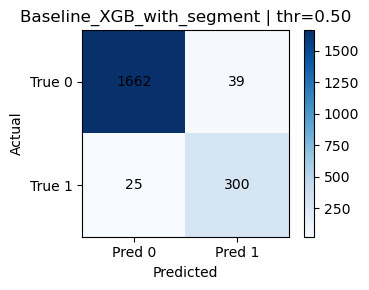

Saved: outputs_nb\figures\cm_Baseline_XGB_with_segment_thrBEST.png


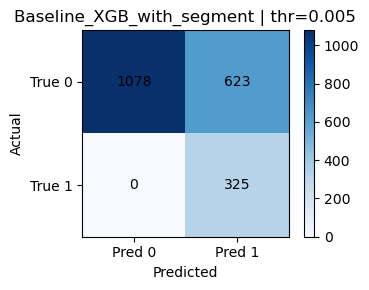

Saved: outputs_nb\figures\cm_Tuned_MLP_no_segment_thr050.png


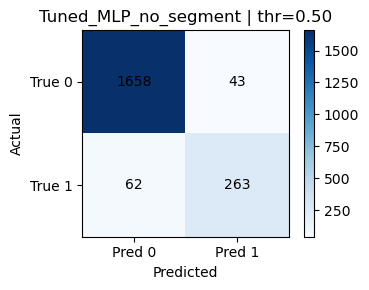

Saved: outputs_nb\figures\cm_Tuned_MLP_no_segment_thrBEST.png


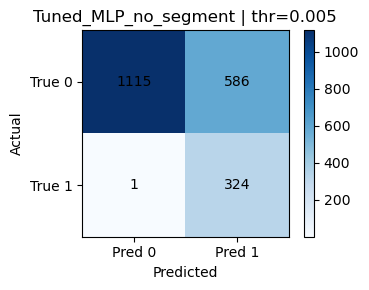

Saved: outputs_nb\figures\cm_Tuned_MLP_with_segment_thr050.png


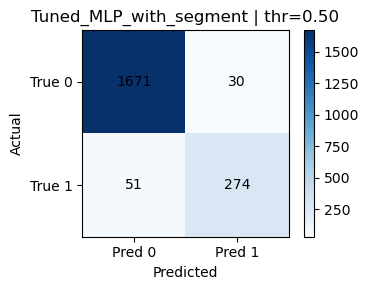

Saved: outputs_nb\figures\cm_Tuned_MLP_with_segment_thrBEST.png


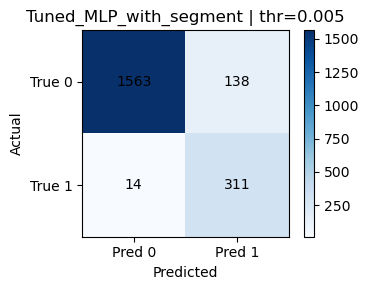

Saved: outputs_nb\figures\cm_Tuned_XGB_no_segment_thr050.png


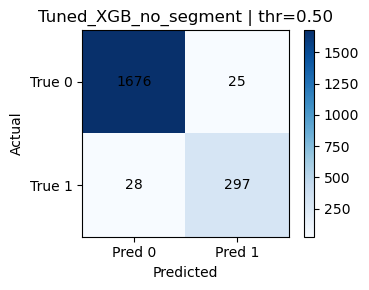

Saved: outputs_nb\figures\cm_Tuned_XGB_no_segment_thrBEST.png


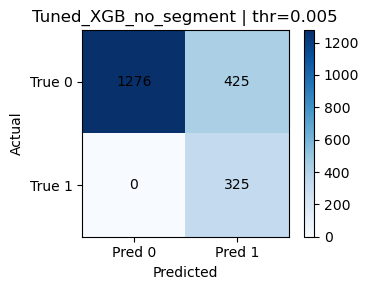

Saved: outputs_nb\figures\cm_Tuned_XGB_with_segment_thr050.png


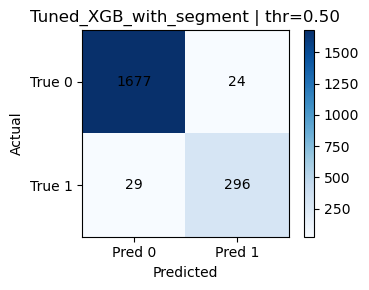

Saved: outputs_nb\figures\cm_Tuned_XGB_with_segment_thrBEST.png


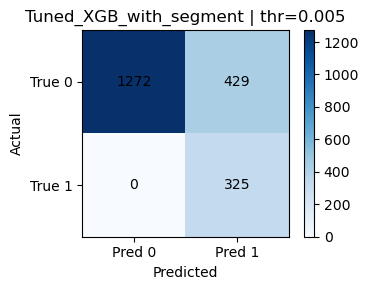

,model_key,thr,accuracy,precision,recall,f1,roc_auc,pr_auc
1,Baseline_LogReg_no_segment,0.155,0.655972,0.314000,0.966154,0.473962,0.920677,0.731488
0,Baseline_LogReg_no_segment,0.500,0.854886,0.530938,0.818462,0.644068,0.920677,0.731488
9,Baseline_LogReg_with_segment,0.115,0.648569,0.311220,0.981538,0.472593,0.931955,0.761168
8,Baseline_LogReg_with_segment,0.500,0.862290,0.546748,0.827692,0.658507,0.931955,0.761168
5,Baseline_MLP_no_segment,0.005,0.615499,0.292505,0.984615,0.451022,0.958940,0.857781
4,Baseline_MLP_no_segment,0.500,0.926950,0.790164,0.741538,0.765079,0.958940,0.857781
13,Baseline_MLP_with_segment,0.010,0.635735,0.303146,0.978462,0.462882,0.956420,0.849252
12,Baseline_MLP_with_segment,0.500,0.930898,0.817869,0.732308,0.772727,0.956420,0.849252
3,Baseline_RF_no_segment,0.030,0.673248,0.328934,0.996923,0.494656,0.985825,0.939899
2,Baseline_RF_no_segment,0.500,0.948174,0.929688,0.732308,0.819277,0.985825,0.939899


In [20]:
def pick_threshold_by_pr(y_true, y_prob, min_precision=0.25):
    thrs = np.linspace(0, 1, 401)
    rows = []
    for t in thrs:
        y_pred = (y_prob >= t).astype(int)
        rows.append({
            "thr": t,
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
        })
    sweep = pd.DataFrame(rows)
    cand = sweep[sweep["precision"] >= min_precision]
    if len(cand) == 0:
        return 0.5, sweep  # fallback
    best_row = cand.iloc[cand["recall"].idxmax()]
    return float(best_row["thr"]), sweep

all_pipes = {}

# baseline pipes
for name, pipe in trained_no.items():
    all_pipes[f"Baseline_{name}_no_segment"] = (pipe, X_test)
for name, pipe in trained_seg.items():
    all_pipes[f"Baseline_{name}_with_segment"] = (pipe, X_test_seg_use)

# tuned pipes
for key, pipe in tuned_pipes.items():
    if key.endswith("no_segment"):
        all_pipes[key] = (pipe, X_test)
    else:
        all_pipes[key] = (pipe, X_test_seg_use)

min_precision = 0.25
thr_rows = []

for key, (pipe, Xte) in all_pipes.items():
    if not hasattr(pipe[-1], "predict_proba"):
        continue

    y_prob = pipe.predict_proba(Xte)[:, 1]
    best_thr, sweep = pick_threshold_by_pr(y_test, y_prob, min_precision=min_precision)


    sweep.to_csv(os.path.join(TAB_DIR, safe_filename(f"thr_sweep_{key}.csv")), index=False)

    # thr=0.50
    m050 = evaluate_pipeline(pipe, Xte, y_test, threshold=0.5)
    plot_cm_heatmap(m050["cm"], f"{key} | thr=0.50", filename=safe_filename(f"cm_{key}_thr050.png"))
    thr_rows.append({"model_key": key, "thr": 0.50, **{k:m050[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}})

    # thr=best
    mb = evaluate_pipeline(pipe, Xte, y_test, threshold=best_thr)
    plot_cm_heatmap(mb["cm"], f"{key} | thr={best_thr:.3f}", filename=safe_filename(f"cm_{key}_thrBEST.png"))
    thr_rows.append({"model_key": key, "thr": best_thr, **{k:mb[k] for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]}})

threshold_report = pd.DataFrame(thr_rows).sort_values(["model_key","thr"])
threshold_report.to_csv(os.path.join(TAB_DIR, "threshold_report_all_models.csv"), index=False)
threshold_report.head(20)


In [21]:
final_df = pd.concat([
    compare_base.assign(type="baseline"),
    compare_tuned.assign(type="tuned")
], ignore_index=True)

final_df = final_df.sort_values(["type","model","scenario"])
final_df.to_csv(os.path.join(TAB_DIR, "final_summary_table.csv"), index=False)
final_df


,type,scenario,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,baseline,no_segment,LogReg,0.854886,0.530938,0.818462,0.644068,0.920677,0.731488
1,baseline,with_segment,LogReg,0.862290,0.546748,0.827692,0.658507,0.931955,0.761168
2,baseline,no_segment,MLP,0.926950,0.790164,0.741538,0.765079,0.958940,0.857781
3,baseline,with_segment,MLP,0.930898,0.817869,0.732308,0.772727,0.956420,0.849252
4,baseline,no_segment,RF,0.948174,0.929688,0.732308,0.819277,0.985825,0.939899
5,baseline,with_segment,RF,0.945212,0.911538,0.729231,0.810256,0.983658,0.929844
6,baseline,no_segment,XGB,0.969891,0.895210,0.920000,0.907436,0.993159,0.969973
7,baseline,with_segment,XGB,0.968411,0.884956,0.923077,0.903614,0.993153,0.969767
8,tuned,no_segment,Tuned_MLP,0.948174,0.859477,0.809231,0.833597,0.977640,0.899358
9,tuned,with_segment,Tuned_MLP,0.960020,0.901316,0.843077,0.871224,0.982314,0.935592


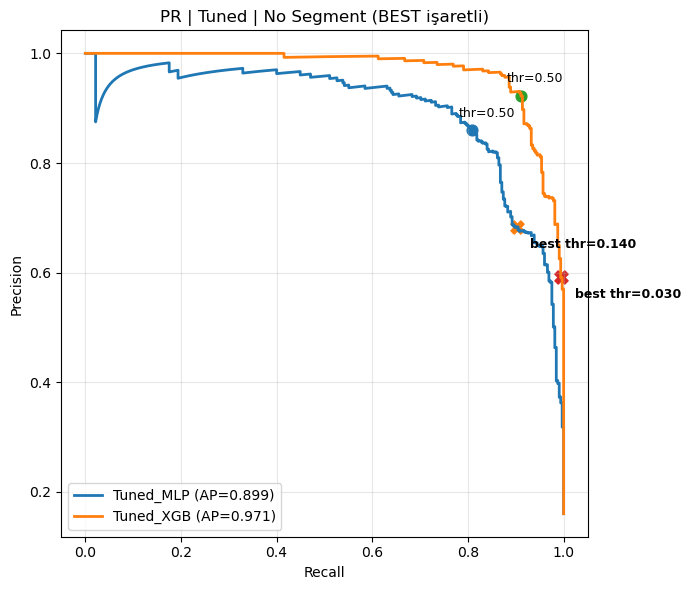

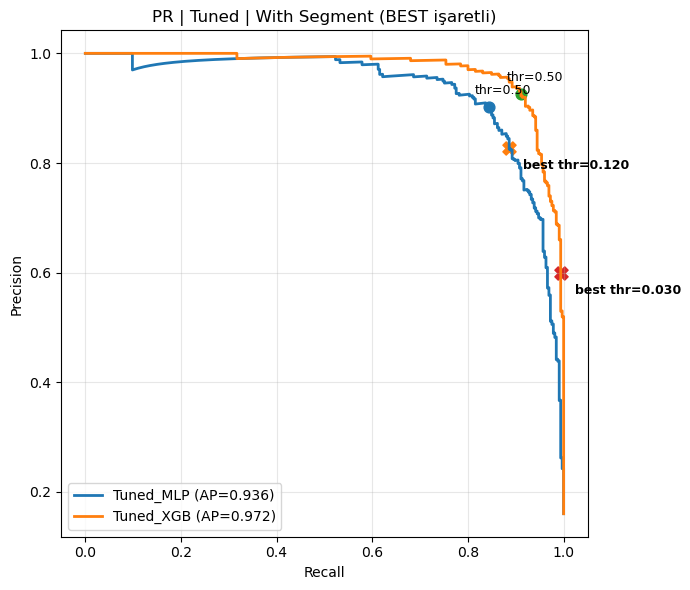

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_all_mark_best(models, X, y, title, save_path, thr_best_dict, mark_thr050=True):
    plt.figure(figsize=(7, 6))

    for name, pipe in models.items():
        y_score = pipe.predict_proba(X)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y, y_score)
        ap = average_precision_score(y, y_score)

        plt.plot(recall, precision, lw=2, label=f"{name} (AP={ap:.3f})")

        # thresholds[j] -> (recall[j+1], precision[j+1])
        def thr_to_point(thr_value):
            if thresholds is None or len(thresholds) == 0:
                return None
            j = int(np.argmin(np.abs(thresholds - thr_value)))
            i = min(j + 1, len(recall) - 1)
            return recall[i], precision[i]

        if mark_thr050:
            p050 = thr_to_point(0.50)
            if p050 is not None:
                x, yv = p050
                plt.scatter([x], [yv], s=60, marker="o")
                plt.annotate("thr=0.50", (x, yv), textcoords="offset points", xytext=(-10, 10), fontsize=9)

        if name in thr_best_dict:
            thr_best = float(thr_best_dict[name])
            pbest = thr_to_point(thr_best)
            if pbest is not None:
                x, yv = pbest
                plt.scatter([x], [yv], s=90, marker="X")
                plt.annotate(
                    f"best thr={thr_best:.3f}",
                    (x, yv),
                    textcoords="offset points",
                    xytext=(10, -15),
                    fontsize=9,
                    fontweight="bold"
                )
        else:
            print(f"[WARN] {name} thr_best_dict içinde yok. keys={list(thr_best_dict.keys())}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, safe_filename(save_path)), dpi=300)
    plt.show()

thr_best_no = {"Tuned_MLP": 0.14, "Tuned_XGB": 0.03}
thr_best_se = {"Tuned_MLP": 0.12, "Tuned_XGB": 0.03}

plot_pr_all_mark_best(
    tuned_no, X_test, y_test,
    "PR | Tuned | No Segment (BEST işaretli)",
    "pr_tuned_no_segment_best_marked.png",
    thr_best_no
)

plot_pr_all_mark_best(
    tuned_se, X_test_seg_use, y_test,
    "PR | Tuned | With Segment (BEST işaretli)",
    "pr_tuned_with_segment_best_marked.png",
    thr_best_se
)
